<a href="https://colab.research.google.com/github/XLDiaz/MLearning_HEConsumption/blob/main/HEConsumption_Forecasting_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [65]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping


import warnings
warnings.filterwarnings('ignore')

In [85]:
df = pd.read_csv("/content/drive/MyDrive/XLDiaz/MLearning_HEConsumption/Data/HEC_Data.csv", delimiter= ",", infer_datetime_format= True)
df=df.loc[:,['Fecha','Potencia_Activa']]
df['Fecha'] = pd.to_datetime(df['Fecha'])
df.set_index('Fecha',inplace=True)
df = df.resample('H').sum()
df.head()

,Potencia_Activa
Fecha,
2006-12-16 17:00:00,152.0240
2006-12-16 18:00:00,217.9320
2006-12-16 19:00:00,204.0140
2006-12-16 20:00:00,196.1140
2006-12-16 21:00:00,183.3880


#LSTM

La tarea es predecir valores para una serie de tiempo **dados los valores de consumo recopilados en Household Energy Consumption Dataset** de consumo de energía de un hogar. Se va a utilizar una **Red Neuronal Recurrente LSTM** de varias capas para poder **predecir valores futuros** de la secuencia.

El modelo se probará sobre los datos muestreados en horas y días.

Se procede a crear el conjunto de datos, normalizarlo y divídalo en conjuntos de entrenamiento y prueba. Además, es necesario conviertirlos en una matriz de conjunto de datos.

In [133]:
dataset = df.Potencia_Activa.values #numpy.ndarray
dataset = df.Potencia_Activa.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset.shape
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [134]:
# Convertir el array de Numpy en una matriz de conjunto de datos
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [145]:
# Transformar al estado X=t y Y=t+1
look_back = 168
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [146]:
X_train.shape

(27791, 168)

In [147]:
Y_train.shape

(27791,)

In [148]:
# Transformar la matriz del conjunto de datos al modo [amples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

**Arquitectura del Modelo**

In [149]:
X_train.shape

(27791, 1, 168)

In [150]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=35 , batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Epoch 1/35
398/398 [==============================] - 4s 6ms/step - loss: 0.0127 - val_loss: 0.0066
Epoch 2/35
398/398 [==============================] - 2s 5ms/step - loss: 0.0097 - val_loss: 0.0062
Epoch 3/35
398/398 [==============================] - 2s 5ms/step - loss: 0.0091 - val_loss: 0.0062
Epoch 4/35
398/398 [==============================] - 2s 5ms/step - loss: 0.0089 - val_loss: 0.0064
Epoch 5/35
398/398 [==============================] - 2s 5ms/step - loss: 0.0088 - val_loss: 0.0061
Epoch 6/35
398/398 [==============================] - 2s 5ms/step - loss: 0.0087 - val_loss: 0.0062
Epoch 7/35
398/398 [==============================] - 2s 5ms/step - loss: 0.0087 - val_loss: 0.0062
Epoch 8/35
398/398 [==============================] - 2s 5ms/step - loss: 0.0085 - val_loss: 0.0059
Epoch 9/35
398/398 [==============================] - 2s 5ms/step - loss: 0.0085 - val_loss: 0.0060
Epoch 10/35
398/398 [==============================] - 3s 8ms/step - loss: 0.0084 - val_loss: 0.0060

In [151]:
# Obtener Predicciones
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invertir las predicciones para obtener los valores originales
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Error Medio Absoluto Entrenamiento:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Error Cuadrático Medio Entrenamiento:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Error Medio Absoluto Datos de Prueba:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Error Cuadrático Medio Datos de Prueba:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Error Medio Absoluto Entrenamiento: 24.29525136174766
Error Cuadrático Medio Entrenamiento: 35.41831780125245
Error Medio Absoluto Datos de Prueba: 21.038047229151807
Error Cuadrático Medio Datos de Prueba: 30.343766596869234


**Error en los datos de entrenamiento y prueba a medida que aumentasn los ciclos**

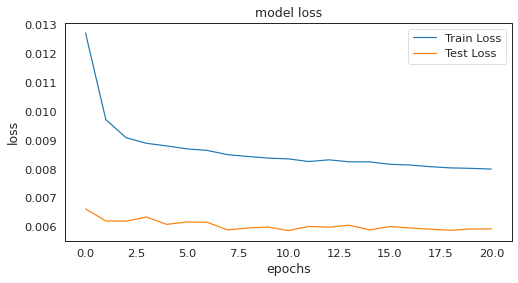

In [152]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [128]:
import matplotlib.ticker as tkr

**Predicción VS Valor Real (500 muestras)**

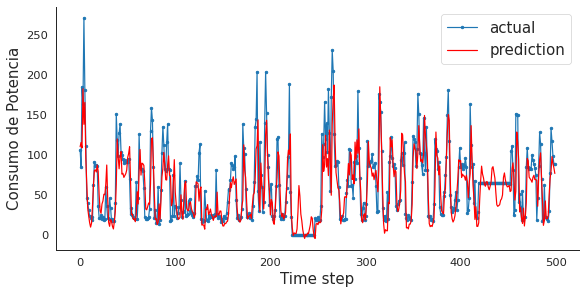

In [153]:
aa=[x for x in range(500)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:500], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:500], 'r', label="prediction")
plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Consumo de Potencia', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

**Predicción VS Valor Real (250 muestras)**

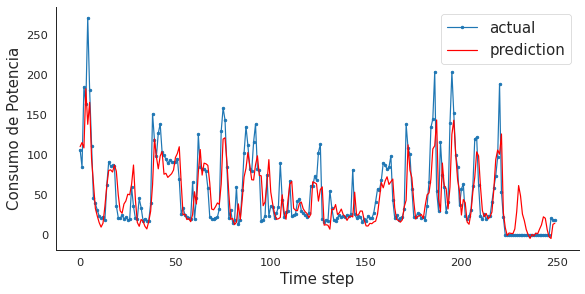

In [154]:
aa=[x for x in range(250)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:250], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:250], 'r', label="prediction")
plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Consumo de Potencia', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

**Predicción VS Valor Real (100 muestras)**

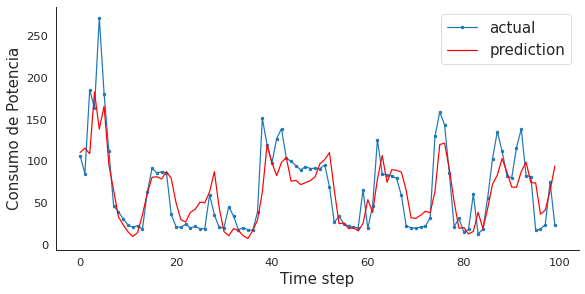

In [155]:
aa=[x for x in range(100)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:100], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:100], 'r', label="prediction")
plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Consumo de Potencia', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();